## Background

In this blog post I'll provide a summary (and an exploration of some of the math) for the research paper [ORPO: Monolithic Preference Optimization without Reference Model](https://arxiv.org/pdf/2403.07691).

Here's the abstract:

> While recent preference alignment algorithms for language models have demonstrated promising results, supervised fine-tuning (SFT) remains imperative for achieving successful convergence. In this paper, we study the crucial role of SFT within the context of preference alignment, emphasizing that a minor penalty for the disfavored generation style is sufficient for preference-aligned SFT. Building on this foundation, we introduce a straightforward and innovative reference model-free monolithic odds ratio preference optimization algorithm, ORPO, eliminating the necessity for an additional preference alignment phase. We demonstrate, both empirically and theoretically, that the odds ratio is a sensible choice for contrasting favored and disfavored styles during SFT across the diverse sizes from 125M to 7B. Specifically, fine-tuning Phi-2 (2.7B), Llama-2 (7B), and Mistral (7B) with ORPO on the UltraFeedback alone surpasses the performance of state-of-the-art language models with more than 7B and 13B parameters: achieving up to 12.20% on AlpacaEval2.0 (Figure 1), 66.19% on IFEval (instruction-level loose, Table 6), and 7.32 in MT-Bench (Figure 12). We release code and model checkpoints for Mistral-ORPO-$\alpha$ (7B) and Mistral-ORPO-$\beta$ (7B).

## Main Takeaways

I took away 5 main points from this paper:

- ORPO does not use a reference model like DPO (in the KL term) or a reward model and initial SFT snapshot like RLHF.
- Instead, ORPO directly trains a preference-aligned Supervised Fine-Tuned (SFT) model.
- The ORPO loss includes a penalty (added to the normal causal LM Negative Log Likelihood loss) which maximizes the likelihood of generating a favored reponse.
- ORPO consistently is preferred by a reward model against SFT and RLHF.
- The ORPOR win rate vs. DPO increases as model size increases.

## Quick Review: DPO and RLHF

In order to better visualize how ORPO differs from DPO and RLHF I'll provide a couple of visuals to highlight those points.

First, from [Chip Huyen's blog post on RLHF](https://huyenchip.com/2023/05/02/rlhf.html), I've highlighted where the SFT model and reward model are used.

<img src="1.png" style="width:100%;">

Next I'll show the DPO loss function, where the reference model is used in the log probability ratios:

<img src="2.png" style="width:100%;">

Finally, from the ORPO paper, a graphic that compares RLHF, DPO and ORPO. The odds ratio is shown on the right (it strongly adapts to chosen reponses and has a weak penalty for rejected responses).

<img src="3.png" style="width:100%;">



## Quick Review: SFT without ORPO

I'll do a quick review of what the loss function looks like for SFT without ORPO. The loss function is cross entropy loss, where the log probabilities $\log(p_i^{(k)})$ of the label tokens (when $y_i$ is True) are average across the input sequence of length $m$:

$$\mathcal{L} = -\frac{1}{m}\sum^m_{k=1}\sum^{|V|}_{i=1}y_i^{(k)}\cdot\log(p_i^{(k)})$$

This loss function is effective for domain adaptation (for next token prediction) but doesn't have a mechanism to penalize rejected responses.

In the ORPO paper they studies the log probabilities of chosen and rejected responses during SFT (without ORPO) and found that both increase over the course of training. In other words, the model does not discriminate between desired and undesired tokens.

<img src="5.png" style="width:100%;">

## ORPO Loss

The ORPO loss function is an enhancement or augmentation of SFT loss:

$$\mathcal{L} = \mathbb{E}_{(x, y_w, y_l)}\big[\mathcal{L}_{SFT} + \lambda \cdot\mathcal{L}_{OR}\big]$$

In this loss function, $\mathcal{L}_{SFT}$ helps the model adapt to the specified subset of the domain. In other words, it does what good ol' SFT does---fine-tune a model toward a given downstream task (chat, QA, reasoning, etc.).

The $\mathcal{L}_{OR}$ term (called relative ratio loss) helps the mode disfavor generations in the rejected responses set.

The term $\lambda$ weighs the relative ratio loss and affects how much the model disfavors rejected responses. An ablation study on this term is done in the appendix which I'll talk about in a bit.

The relative ratio loss is defined as:

$$\mathcal{L}_{OR} = -\log\sigma\big(\log\frac{\textbf{odds}_\theta(y_w|x)}{\textbf{odds}_\theta(y_l|x)}\big)$$

This loss contains the **odds ratio** which I'll talk about next.

## Odds Ratio

The odds ratio is a ratio of:

- the odds of generating the desired output sequence $y_w$ given an input sequence $x$
- and the odds of generating the undesired output sequence $y_l$ given an input sequence $x$.

Odds are defined as follows:

$$\textbf{odds}_\theta(y|x) = \frac{P_\theta(y|x)}{1-P_\theta(y|x)}$$

Where $P_\theta(y|x)$ is the likelihood that the model $\theta$ will generate $y$ given input $x$.

> Intuitively $\textbf{odds}_\theta(y|x)=k$ implies that it is $k$ times more likely for the model $\theta$ to generate the output sequence $y$ than not generating it $y$.

Note that as the likelihood $P$ increases, $1-P$ decreases and the **odds** increase.

In the following visual I show how we can plot odds as $\frac{x}{1-x}$ in Desmos and see how quickly the odds increase as likelihood increases.

<img src="6.png" style="width:100%;">

I also plot the relative ratio loss as a function of the odds ratio in desmos. You can see that as the odds ratio (in the graph denoted by $x$) increases the loss function decreases. When the odds ratio increases, the numerator increases relative to the denominator. This means that the odds that the model will generated desired responses increases relative to the odds that it will generated undesired responses. In other words, as the model is trained and learns to minimize the loss, it also learns to maximize the likelihood of generating desired responses.

<img src="7.png" style="width:100%;">

In the ORPO paper, they study how the log odds ratio and log probabilities of chosen and rejected responses vary over the course of training. They find that as the model is trained longer, the log odds ratio increases and after awhile, the log probabilities of rejected responses decreases (while chosen log probs continue to increase). This show the discriminating behavior of the relative ratio loss as compared to SFT loss.

<img src="8.png" style="width:100%;">

## Gradient of ORPO Loss

I'll go through some of the intuition provided in the paper around the gradient of the ORPO loss function, which contains two factors: $\delta(d)$ and $h(d)$ which are functions of the dataset $d$ which contains inputs $x$, desired responses $y_w$ and undesired responses $y_l$.

<img src="9.png" style="width:100%;">

### $\delta(d)$

I'll start by looking at $\delta(d)$ first: when the odds of the desired responses are relatively higher than the undesired responses, this term will converge to 0.

In the desmos graph below, $x$ represents the odds ratio and so $\delta(d)$ takes the form of $\frac{1}{1+x}$:

<img src="10.png" style="width:100%;">

For the following concept:

> $\delta(d)$ will play the role of a penalty term. accelerating the parameter updates if the model is more likely to generate the rejected responses.

I found the following rearranging of $\delta(d)$ terms more intuitive:

<br>

$$\delta(d) = \big[1 + \frac{\textbf{odds}_\theta P(y_w|x)}{\textbf{odds}_\theta P(y_l|x)}\big]^{-1}$$

I'll replace $1$ with an equivalent fraction that has the same denominator as the odds ratio:

<br>

$$\delta(d) = \big[\frac{\textbf{odds}_\theta P(y_l|x)}{\textbf{odds}_\theta P(y_l|x)} + \frac{\textbf{odds}_\theta P(y_w|x)}{\textbf{odds}_\theta P(y_l|x)}\big]^{-1}$$

Now I can easily add together the fractions inside the brackets because they have the same denominator:

<br>

$$\delta(d) = \big[\frac{\textbf{odds}_\theta P(y_l|x) + \textbf{odds}_\theta P(y_w|x)}{\textbf{odds}_\theta P(y_l|x)}\big]^{-1}$$

Raising a fraction to the $-1$ power is the same as flipping it:

<br>

$$\delta(d) = \big[\frac{\textbf{odds}_\theta P(y_l|x)}{\textbf{odds}_\theta P(y_l|x) + \textbf{odds}_\theta P(y_w|x)}\big]$$

<br>

I find this form of $\delta(d)$ more intuitive. Here you can directly see that as the odds of generating rejected responses (the numerator) increases, the overall fraction increases and thus the gradient increases, accelerating the parameter update.

### $h(d)$

The second term of the ORPO loss gradient is $h(d)$ which has the form:

$$h(d) = \frac{\nabla_\theta\log P_\theta(y_w|x)}{1-P_\theta(y_w|x)} - \frac{\nabla_\theta\log P_\theta(y_l|x)}{1-P_\theta(y_l|x)}$$

> For the chosen responses, this accelerates the model's adaptation toward the distribution of chosen responses as the likelihood increases.

As the likelihood of chosen reponses ($P_\theta(y_w|x)$) increases, the denominator ($1-P$) decreases and the first fraction increases, increasing the gradient and accelerating the model's adaptation toward predicting chosen responses.

On the other hand, as the likelihood of the rejected response increases the denominator decreases and the second fraction increases, decreasing the gradient and slowing down the model's adapation toward the rejected response distribution.

I've summarized the behavior of the two terms below:

<img src="11.png" style="width:100%;">

I see these two terms, $\delta(d)$ and $h(d)$, contrasting each other and keeping the gradients from vanishing or exploding.

## Training

In this section I'll recap the training details provided in the paper.

### Models

The authors trained the following models for SFT, PPO, DPO and ORPO to compare results across each other:

- OPT (125M to 1.3B).
- Phi-2 (2.7B).
- Llama 2 (7B).
- Mistral (7B).

They used the following training techniques and hyperparameters:

- Flash Attention 2.
- Deep Speed Zero 2 (for OPT series and Phi-2).
- FSDP (Fully Sharded Data Parallel) for Llama-2 and Mistral (both 7B).
- AdamW and paged Adam optimizers.
- Linear Warmup with Cosine Decay.
- Input length of 1024 (HH dataset) and 2048 (UltraFeedback dataset).
- SFT: Max LR of 1e-5, trained for 1 epoch.
- DPO: $\beta$=0.1, LR = 5e-6, 3 epochs.
- ORPO: LR=8e-6, 10 epochs.

<img src="12.png" style="width:50%;">

### Datasets

- Anthropic's HH-RLHF.
- Binarized UltraFeedback.

### Reward Model

The reward model is used to score the responses from the different models. They trained OPT 250M and 1.3B on each dataset for a single epoch.

## Results

Their ORPO model performed better than their SFT, DPO and PPO models for each model family for AlpacaEval 1.0 and 2.0 (corrected for length-bias in models).

<img src="13.png" style="width:100%;">

On the MT-Bench dataset they found that:

> In comparison to $\lambda$ = 0.1, Mistral+ORPO (7B) with $\lambda$ = 1.0 performs worse in extraction, math and reasoning=, which are the categories that generally require deterministic answers. On the other hand, it performs better in STEM, humanities, and roleplay, which ask the generations without hard answers.

I will note that STEM contains science, engineering and math which can contain deterministic answers so I'm not sure this distinction between the two $\lambda$ values holds.

On the HH-RLHF dataset, ORPO had high win-rates for 125M and 350M models against SFT and SFT+PPO, and high win-rate for 1.3B against SFT+DPO.

<img src="14.png" style="width:100%;">

The trend was the same for the UltraFeedback dataset:

<img src="15.png" style="width:100%;">

### Computation Efficiency

The authors found the following results as relating to computational efficiency:

- ORPO does not require a reference model which in RLHF and DPO is the model trained with SFT used during training to keep the parameterized model from degenerating.
- DPO and RLHF require two SFT models: a frozen reference model (KL term) and the model being trained.
- ORPO only has one model: the model being trained with SFT. This requires half the forward passes of DPO or RLHF.

## Limitations

The authors highlighted that their work lacks comparisons with alignment algorithms other than PPO and DPO (such KTO or IPO). They also only trained models that are up to 7B parameters in size.

## Future Work

The authors highlighted three areas of future work:

- Evaluate ORPO performance on models larger than 7B parameters.
- Evaluate the impact of ORPO on pretrained models.
- Expand to consecutive preference alignment algorithms.

---

In the following sections I walk through some of the math in the paper.

## Section 4: Odds Ratio Preference Optimization

### 4.1 Preliminaries

> Given an input sequence $x$, the average log-likelihood of generating the output sequence $y$, of length $m$ tokens, is computed as:

$$\log P_\theta(y|x) = \frac{1}{m}\sum^m_{t=1} \log P_\theta(y_t|x,y_{<t})$$

Excellently worded explanations from ChatGPT (emphasis mine):

> $\frac{1}{m}$​: This term represents the reciprocal of the length of the output sequence $y$. It's the inverse of the number of tokens in the output sequence. This term normalizes the sum of log probabilities over the length of the sequence, **ensuring that longer sequences don't disproportionately influence the average log-likelihood**.

> $\log P_\theta​(y_t​∣x,y_{<t}​)$: This term represents the logarithm of the probability of generating the current token $y_t$​ given the input sequence $x$ and the preceding tokens $y_{<t}$. It measures how likely the model thinks the current token $y_t$​ is, given the input $x$ and the previously generated tokens $y_{<t}$​.

Here's what $log(x)$ looks like:

<img src="16.png" style="width:100%;">

The odds of generating the output sequence $y$ given an input sequence $x$:

$$\textbf{odds}_\theta(y|x) = \frac{P_\theta(y|x)}{1-P_\theta(y|x)}$$

> Intuitively $\textbf{odds}_\theta(y|x)=k$ implies that it is $k$ times more likely for the model $\theta$ to generate the output sequence $y$ than not generating it.

Writing that out:

$$\textbf{odds}_\theta(y|x)= \frac{P_\theta(y|x)}{1-P_\theta(y|x)} = k$$

<br>

$$\frac{P_\theta(y|x)}{1-P_\theta(y|x)} = k$$

<br>

$$P_\theta(y|x) = k[1-P_\theta(y|x)]$$

> it is $k$ times more likely to generate $y$ (i.e. $P_\theta)$) than not generating it ($1-P_\theta$).

> The odds ratio of the chosen response $y_w$ over the rejected response:

$$\textbf{OR}_\theta(y_w,y_l) = \frac{\textbf{odds}_\theta(y_w|x)}{\textbf{odds}_\theta(y_l|x)}$$

> indicates how much more likely it is for the model $\theta$ to generate $y_w$ than $y_l$ given input $x$.

If the odds ratio is some value $r$:

$$\frac{\textbf{odds}_\theta(y_w|x)}{\textbf{odds}_\theta(y_l|x)} = r$$

<br>

$$\textbf{odds}_\theta(y_w|x) = r \cdot \textbf{odds}_\theta(y_l|x)$$

The odds of the model generating a chosen response is $r$ times the odds of it generating a rejected response.

### 4.2 Objective Function of ORPO

$$\mathcal{L}_{ORPO}=\mathbb{E}_{(x,y_w,y_l)}\big[ \mathcal{L}_{SFT} + \lambda \cdot \mathcal{L}_{OR}\big]$$

Where:

$$\mathcal{L}_{SFT} \text{ is the supervised fine-tuning loss (maximizes the likelihood of generating the reference tokens)}$$

<br>

$$\mathcal{L}_{OR} \text{ is the relative ratio loss (maximizes the odds ratio between the likelihood of generating the favored response } y_w\text{ and the disfavored response } y_l)$$

#### Relative Ratio Loss $\mathcal{L}_{OR}$

$$\mathcal{L}_{OR} = - \log \sigma\big(\log \frac{\textbf{odds}_\theta(y_w|x)}{\textbf{odds}_\theta(y_l|x)} \big)$$

The term inside log-sigmoid, $\log \frac{\textbf{odds}_\theta(y_w|x)}{\textbf{odds}_\theta(y_l|x)}$, increases as the odds of generating chosen responses increases (and therefore increases as the likelihood of the model generating chosen responses increases).

$\mathcal{L}_{OR}$, represented below by $-\log\sigma(x)$, decreases as x increases, meaning the loss decreases as the likelihood and the odds of the model generating chosen responses increases.

<img src="17.png" style="width:100%;">

Minimizing $\mathcal{L}_{OR}$ means maximizing $\frac{\textbf{odds}_\theta(y_w|x)}{\textbf{odds}_\theta(y_l|x)}$

### 4.3 Gradient of ORPO

$$\nabla_\theta\mathcal{L}_{OR}=\delta(d) \cdot h(d)$$

Where:

$$\delta(d) \text{ penalizes the wrong predictions}$$
$$h(d) \text{ contrasts between chosen and rejected responses}$$
$$d = (x, y_w, y_l) \sim D$$

Full form of $\delta(d)$:

$$\delta(d) = \big[1 + \frac{\textbf{odds}_\theta P(y_w|x)}{\textbf{odds}_\theta P(y_l|x)} \big]^{-1}$$

<br>



Visualizing this as $\frac{1}{1+x}$, as the odds ratio increases (odds of generating favored responses increases) $delta(d)$ decreases.

<img src="18.png" style="width:100%;">

Rewriting that by expanding out the fraction in multiple steps. First, replace $1$ with an equivalent (rejected odds divided by rejected odds):

$$\delta(d) = \big[\frac{\textbf{odds}_\theta P(y_l|x)}{\textbf{odds}_\theta P(y_l|x)}  + \frac{\textbf{odds}_\theta P(y_w|x)}{\textbf{odds}_\theta P(y_l|x)} \big]^{-1}$$

Now that they have the same denominator, add the fractions:

<br>

$$\delta(d) = \big[\frac{\textbf{odds}_\theta P(y_l|x) +\textbf{odds}_\theta P(y_w|x)}{\textbf{odds}_\theta P(y_l|x)} \big]^{-1}$$

Taking the inverse (exponent of $-1$), flips the fraction:

<br>

$$\delta(d) = \big[\frac{\textbf{odds}_\theta P(y_l|x)}{\textbf{odds}_\theta P(y_l|x) +\textbf{odds}_\theta P(y_w|x)} \big]$$

I find this version more intuitive as it's easier to see that as the odds of generating rejected responses increases, $\delta(d)$ **increases**. As the odds of generating favored responses increases, $\delta(d)$ **decreases**.  

> When the odds of the favored responses are relatively higher than the disfavored responses, $\delta(d)$ will converge to 0.

> This indicates that $\delta(d)$ will play the role of a penalty term, accelerating the parameter updates  
> if the model is more likely to generate the rejected responses.

Full form of $h(d)$:

$$h(d) = \frac{\nabla_\theta\log P_\theta(y_w|x)}{1-P_\theta(y_w|x)} - \frac{\nabla_\theta\log P_\theta(y_l|x)}{1-P_\theta(y_l|x)}$$

> $h(d)$ implies a weighted contrast of the two gradients from the chosen and rejected responses. Specifically, $1-P(y|x)$ in the denominators amplifies the gradients when the corresponding side of the likelihood $P(y|x)$ is low. **For the chosen responses, this accelerates the model's adaptation toward the distribution of chosen responses as the likelihood increases.**

The last sentence (that I bolded) clarifies the concept (that the previous sentence muddied for me). As $P_\theta(y_w|x)$ increases, $1 - P_\theta(y_w|x)$ decreases (towards 0) and the fraction $\frac{\nabla_\theta\log P_\theta(y_w|x)}{1-P_\theta(y_w|x)}$ increases (i.e. "this accelerates the model's adaptation toward the distribution of chosen responses as the likelihood increases.").

Conversely, as $P_\theta(y_l|x)$ increases (the likelihood of the model generating rejected responses), $1 - P_\theta(y_l|x)$ decreases (towards 0) and the fraction $\frac{\nabla_\theta\log P_\theta(y_l|x)}{1-P_\theta(y_l|x)}$ increases. $h(d)$ gets smaller, slowing the parameter updates since the model is more likely to generate the rejected responses.

My takeaway from the explanation of $\delta(d)$ and $h(d)$ is that they are opposing forces that keep each other in check. If the model is more likely to generate rejected responses, $\delta(d)$ accelerates the parameter updates  (i.e. increases the gradient) and $h(d)$ slows down the parameter updates (decreases the gradient). If the model is more likely to generate favored responses, $\delta(d)$ slows down the parameter update (decreases the gradient) and $h(d)$ accelerates the parameter update (increases the gradient). The intuition (I think) is that if either term gets too large or too small, the other term counters it so you don't have vanishing or exploding gradients.

## Section 7.1: Comparison to Probability Ratio

The following equations are slightly modified equations from the paper, defining their experiment comparing probability ratio (PR) to odds ratio (OR):

$X_1$ and $X_2$ are sampled from a uniform probability distribution.

$$X_1, X_2 \sim \text{Unif}(0,1)$$



$Y_{PR}$ is the log probability ratio:

$$Y_{PR} \sim \beta(\log\frac{X_1}{X_2}) = \beta(\log X_1 - \log X_2)$$

$Y_{OR}$ is the log odds ratio:

$$Y_{OR} = \log(\frac{\textbf{odds}(X_1)}{\textbf{odds}(X_2)}) = \log\big(\frac{X_1}{1-X_1}\big) - \log\big(\frac{X_2}{1-X_2}\big)$$

I used Claude 3's help in explaining the above equations and translating them to code so I could re-run the experiment in the paper:

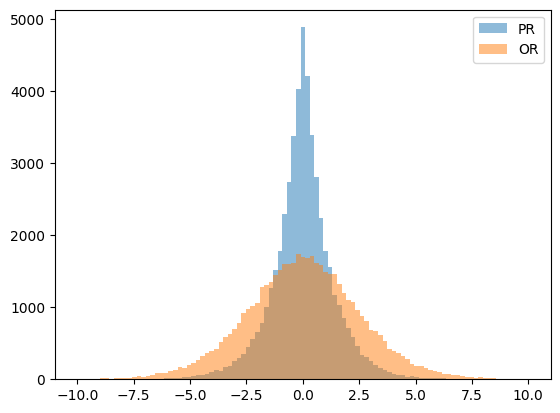

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample x1 and x2 from Uniform(0, 1)
x1 = np.random.uniform(0, 1, 50000)
x2 = np.random.uniform(0, 1, 50000)

# Probability Ratio
beta = 1.0  # Set the value of the proportionality constant
y_pr = beta * (np.log(x1) - np.log(x2))

# Odds Ratio
y_or = np.log(x1 / (1 - x1)) - np.log(x2 / (1 - x2))

# histogram bins
bins = np.linspace(-10, 10, 100)

plt.hist(y_pr, bins, alpha=0.5, label='PR')
plt.hist(y_or, bins, alpha=0.5, label='OR')
plt.legend(loc='upper right')
plt.show()

## TRL Library Implementation

$$\mathcal{L}_{OR} = - \log \sigma\big(\log \frac{\textbf{odds}_\theta(y_w|x)}{\textbf{odds}_\theta(y_l|x)} \big)$$

Given that:

$$\textbf{odds}_\theta(y|x) = \frac{P_\theta(y|x)}{1-P_\theta(y|x)}$$

Plugging in the odds function:

$$\mathcal{L}_{OR} = - \log \sigma\big(\log \frac{\textbf{odds}_\theta(y_w|x)}{\textbf{odds}_\theta(y_l|x)} \big) = -\log\sigma(\log(\frac{\frac{P_\theta(y_w|x)}{1-P_\theta(y_w|x)}}{\frac{P_\theta(y_l|x)}{1-P_\theta(y_l|x)}}))$$

Using log property of division:

$$-\log\sigma(\log(\frac{\frac{P_\theta(y_w|x)}{1-P_\theta(y_w|x)}}{\frac{P_\theta(y_l|x)}{1-P_\theta(y_l|x)}})) = -\log\sigma(\log(\frac{P_\theta(y_w|x)}{1-P_\theta(y_w|x)}) - \log({\frac{P_\theta(y_l|x)}{1-P_\theta(y_l|x)}}))$$

Using log property of division again:

<br>

$$= -\log\sigma(\log P_\theta(y_w|x)- \log(1-P_\theta(y_w|x)) - \log P_\theta(y_l|x) + \log (1-P_\theta(y_l|x)))$$

Rewriting so it's cleaner:

<br>

$$-\log\sigma\big(\log P_\theta(y_w|x)- \log P_\theta(y_l|x) - \big[\log(1-P_\theta(y_w|x))  - \log(1-P_\theta(y_l|x))\big]\big)$$

In the code below the components of this line:

```python
log_odds = (policy_chosen_logps - policy_rejected_logps) - (
            torch.log1p(-torch.exp(policy_chosen_logps)) - torch.log1p(-torch.exp(policy_rejected_logps))
        )
```

correspond to the following math as follows:


```python
policy_chosen_logps - policy_rejected_logps
```

$$\log P_\theta(y_w|x)- \log P_\theta(y_l|x)$$

<br>
<br>

```python
torch.log1p(-torch.exp(policy_chosen_logps)) - torch.log1p(-torch.exp(policy_rejected_logps))
```

$$\big[\log(1-P_\theta(y_w|x)) - \log(1-P_\theta(y_l|x))\big]$$

```python
def odds_ratio_loss(
        self,
        policy_chosen_logps: torch.FloatTensor,
        policy_rejected_logps: torch.FloatTensor,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        """Compute ORPO's odds ratio (OR) loss for a batch of policy and reference model log probabilities.

        Args:
            policy_chosen_logps: Log probabilities of the policy model for the chosen responses. Shape: (batch_size,)
            policy_rejected_logps: Log probabilities of the policy model for the rejected responses. Shape: (batch_size,)

        Returns:
            A tuple of three tensors: (losses, chosen_rewards, rejected_rewards).
            The losses tensor contains the ORPO loss for each example in the batch.
            The chosen_rewards and rejected_rewards tensors contain the rewards for the chosen and rejected responses, respectively.
            The log odds ratio of the chosen responses over the rejected responses ratio for logging purposes.
            The `log(sigmoid(log_odds_chosen))` for logging purposes.
        """

        # Derived from Eqs. (4) and (7) from https://arxiv.org/abs/2403.07691 by using log identities and exp(log(P(y|x)) = P(y|x)
        log_odds = (policy_chosen_logps - policy_rejected_logps) - (
            torch.log1p(-torch.exp(policy_chosen_logps)) - torch.log1p(-torch.exp(policy_rejected_logps))
        )
        sig_ratio = F.sigmoid(log_odds)
        ratio = torch.log(sig_ratio)
        losses = self.beta * ratio

        chosen_rewards = self.beta * (policy_chosen_logps.to(self.accelerator.device)).detach()
        rejected_rewards = self.beta * (policy_rejected_logps.to(self.accelerator.device)).detach()

        return losses, chosen_rewards, rejected_rewards, torch.mean(ratio).item(), torch.mean(log_odds).item()
```